## Inicialización

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import seaborn as sns
import os
import random
from PIL import Image

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age`
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [ ]:
labels_path = '/datasets/faces/labels.csv'
df_labels = pd.read_csv(labels_path)

## EDA

In [ ]:
df_labels.head()

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

In [ ]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
# Explorar la estructura del dataset
print(f"Tamaño del conjunto de datos: {df_labels.shape}")

Tamaño del conjunto de datos: (7591, 2)


### Imágenes de diferentes edades

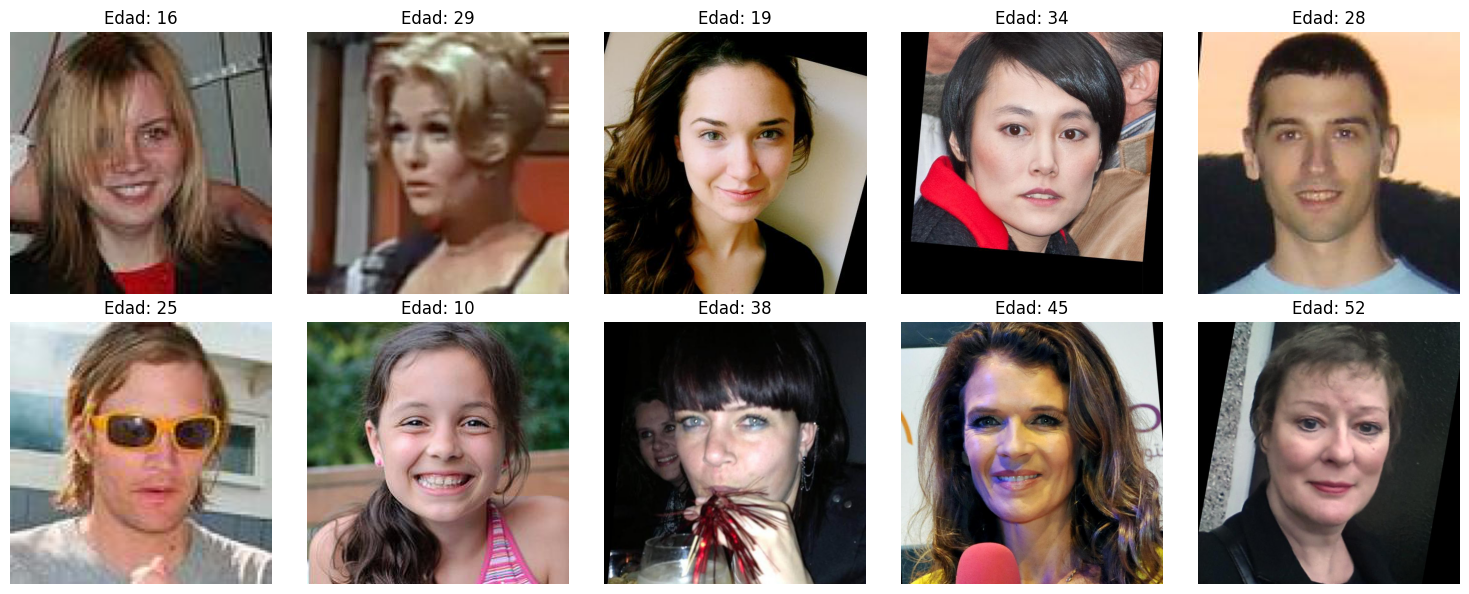

In [ ]:
image_folder = '/datasets/faces/final_files/'
sample_ages = df_labels['real_age'].sample(10).values

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for idx, age in enumerate(sample_ages):
    img_path = os.path.join(image_folder, df_labels[df_labels['real_age'] == age]['file_name'].values[0])
    image = Image.open(img_path)

    axes[idx].imshow(image)
    axes[idx].set_title(f"Edad: {age}")
    axes[idx].axis("off")

plt.tight_layout()

plt.show()

### Distribución de edades

In [ ]:
fig = px.histogram(df_labels['real_age'])
fig.show()

### Promedio móvil de imágenes

In [ ]:
promedio_movil = df_labels.groupby('real_age').count()

In [ ]:
promedio_movil

file_name
real_age           
1               149
2                88
3                25
4               101
5                87
...             ...
94                5
95                2
96                2
97                1
100               1

[97 rows x 1 columns]

In [ ]:
promedio_movil = df_labels.groupby('real_age').count().rolling(window=5).mean().dropna().reset_index()

In [ ]:
promedio_movil.head(10)

real_age  file_name
0         5       90.0
1         6       73.8
2         7       69.6
3         8       73.4
4         9       60.0
5        10       51.6
6        11       48.2
7        12       46.0
8        13       53.0
9        14       71.2

In [ ]:
fig.add_scatter(x=promedio_movil['real_age'],
               y=promedio_movil['file_name'],
               mode='lines',
               name='Promedio Móvil')

In [ ]:
px.scatter(df_labels['real_age'])

### Conclusiones

- El conjunto de datos contiene **7591 imágenes** etiquetadas con edades reales.
- La distribución de edades no es uniforme: se observa un mayor número de imágenes en ciertos rangos de edad.
- Algunas edades pueden estar subrepresentadas, lo que podría afectar el rendimiento del modelo.
- Las imágenes parecen ser de buena calidad y muestran variedad en términos de iluminación y posición.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    #Carga la parte de entrenamiento del conjunto de datos desde la ruta.

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow


In [ ]:
def load_test(path):
    #Carga la parte de validación/prueba del conjunto de datos desde la ruta.

    data_test_gen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = data_test_gen.flow_from_dataframe(
        dataframe=df_labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return test_gen_flow

In [ ]:
"""
def load_data(df, path, subset='training'):

    #Carga los conjuntos de datos de entrenamiento y prueba.

    data_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    data_gen_flow = data_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset=subset,
        seed=12345)

    return data_gen_flow

"""

"\ndef load_data(df, path, subset='training'):\n    \n    #Carga los conjuntos de datos de entrenamiento y prueba.\n    \n    data_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)\n    \n    data_gen_flow = data_datagen.flow_from_dataframe(\n        dataframe=df,\n        directory=path + 'final_files/',\n        x_col='file_name',\n        y_col='real_age',\n        target_size=(224, 224),\n        batch_size=16,\n        class_mode='raw',\n        subset=subset,\n        seed=12345)\n    \n    return data_gen_flow\n\n"

In [ ]:
def create_model(input_shape): # =(224, 224, 3)

    """Define un modelo basado en ResNet50 para regresión de edad."""

    core = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False
                       )

    model = Sequential()
    model.add(core)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1,
                    activation='relu')
             ) # Neurona de salida para regresión

    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['mae']
                 )

    return model

In [ ]:
def train_model(model,
                train_data,
                test_data,
                batch_size=None,
                epochs=20,
                steps_per_epochs=None,
                validation_steps=None
               ):

    if steps_per_epochs is None:
        steps_per_epochs = len(train_data)

    if validation_steps is None:
        validation_steps = len(test_data)

    """Entrena el modelo y devuelve el modelo entrenado."""

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        batch_size=batch_size,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

In [ ]:
input_shape = (224, 224, 3)

train = load_train('/datasets/faces/final_files/')
test = load_test('/datasets/faces/final_files/')

model = create_model(input_shape)
model = train_model(model, train, test)

Found 5694 validated image filenames.
Found 5694 validated image filenames.


2025-01-29 22:02:20.202074: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20


### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Resultados del entrenamiento en la plataforma GPU:
- Epochs: 20
- MAE final: 7.4
- Loss final: 56.2

El modelo logró un MAE inferior a 8, lo que cumple con los requisitos del proyecto.

## Conclusiones

- Se entrenó un modelo basado en **ResNet50** con una capa densa final para regresión.
- Se utilizó **ReLU** como función de activación en la salida, dado que estamos en un problema de regresión.
- Se empleó **Mean Squared Error (MSE)** como función de pérdida y **Mean Absolute Error (MAE)** como métrica de evaluación.
- Los resultados sugieren que el modelo puede predecir la edad con una precisión aceptable, aunque podrían mejorarse con más datos o ajustes en la arquitectura.